Ejercicio - TV Movies Dataset con Dask
En este caso vamos a usar un conjunto de datos de películas y series de televisión de Amazon Prime, en donde se encuentran las criticas(reviews) que hacen los usuarios.

In [1]:
%%time
import gzip
import json
import string
import re

import numpy as np                                                               
import matplotlib.pyplot as plt

#import nltk # imports the natural language toolkit
import pandas as pd
import plotly

from collections import Counter
from datetime import datetime
#from sklearn.feature_extraction.text import CountVectorizer

from IPython.display import display

#nltk.download('punkt')

CPU times: total: 594 ms
Wall time: 618 ms


Instalación de librerías para computación distribuida

In [2]:
#Dask Libraries
# pip install "dask[complete]"   --upgrade
# pip install "dask[dataframe]" 
import json


import dask.dataframe as dd
from dask.diagnostics import ProgressBar 
from dask.distributed import Client, progress
import dask.bag as db

Conexión a un scheduler de Dask externo y asignación de recursos

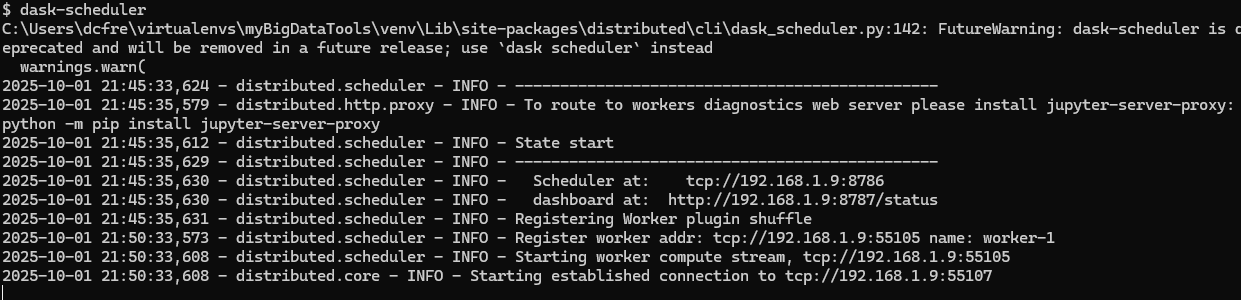

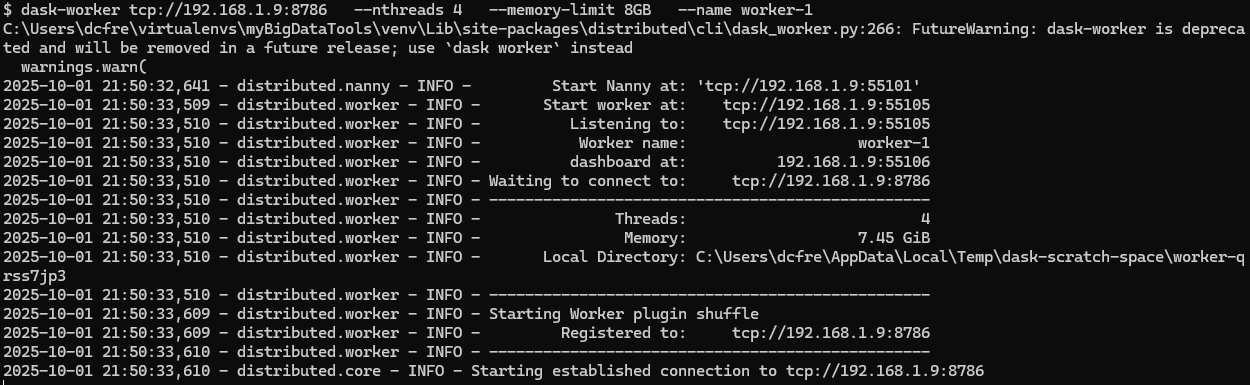

Conectar desde Python
Una vez lanzado el scheduler y los workers, el cliente se conecta desde Python simplemente con:

In [3]:
from dask.distributed import Client
client = Client("tcp://127.0.0.1:8786")
client

<Client: 'tcp://192.168.1.9:8786' processes=1 threads=4, memory=7.45 GiB>

2025-10-01 22:51:45,131 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


Ver los recursos activos por worker
Puedes inspeccionar los recursos y estado de cada worker con:

In [4]:
client.scheduler_info()["workers"]

{'tcp://127.0.0.1:50697': {'type': 'Worker',
  'id': 'worker-1',
  'host': '127.0.0.1',
  'resources': {},
  'local_directory': 'C:\\Users\\dcfre\\AppData\\Local\\Temp\\dask-scratch-space\\worker-g5whd_2e',
  'name': 'worker-1',
  'nthreads': 4,
  'memory_limit': 8000000000,
  'last_seen': 1759376443.4377768,
  'services': {'dashboard': 50698},
  'metrics': {'task_counts': {},
   'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
   'digests_total_since_heartbeat': {'latency': 0.005308389663696289,
    'tick-duration': 0.4922459125518799},
   'managed_bytes': 0,
   'spilled_bytes': {'memory': 0, 'disk': 0},
   'transfer': {'incoming_bytes': 0,
    'incoming_count': 0,
    'incoming_count_total': 0,
    'outgoing_bytes': 0,
    'outgoing_count': 0,
    'outgoing_count_total': 0},
   'event_loop_interval': 0.020044217109680174,
   'cpu': 0.0,
   'memory': 91615232,
   'time': 1759376442.9453511,
   'host_net_io': {'read_bps': 121.43762723919254, 'write_bps': 0.0},
   'host_di

Creación de cluster

In [7]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=6, threads_per_worker=2, memory_limit='4GB', dashboard_address=":8787",local_directory="/tmp/dask")
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64641,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:64676,Total threads: 2
Dashboard: http://127.0.0.1:64681/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:64644,


Cluster definido
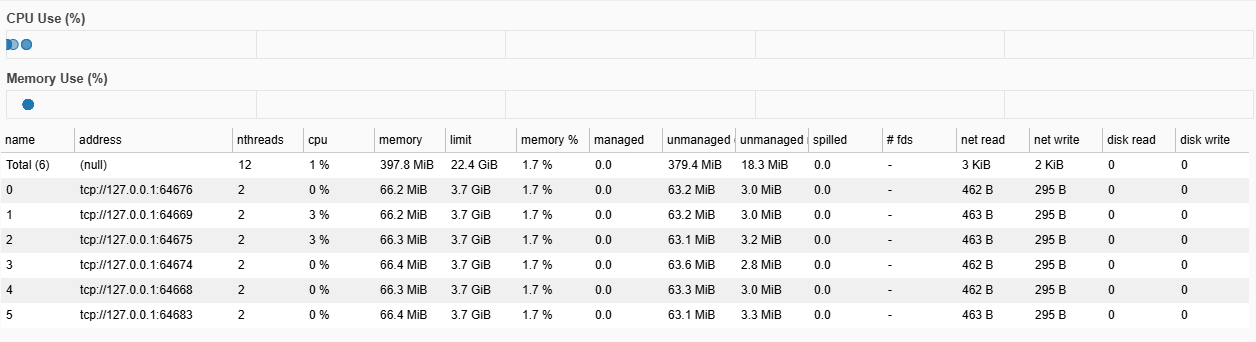

Lectura del archivo del dataset
Note: Esta es una aproximación diferente a la lectura con Pandas, dask cuenta con un formato denominado dask bag, que trabaja mucho mejor con archivos json que es el caso del conjunto de datos de Movies.

In [8]:
bag_video_dataset = db.read_text('Movies_and_TV_5.json', blocksize='40MB').map(json.loads)

In [9]:
bag_video_dataset

dask.bag<loads, npartitions=49>

In [10]:
bag_video_dataset.count().compute()  # Count total number of records

1697533

In [11]:
bag_video_dataset.take(2) #like head in pandas, show the first records

({'reviewerID': 'ADZPIG9QOCDG5',
  'asin': '0005019281',
  'reviewerName': 'Alice L. Larson "alice-loves-books"',
  'helpful': [0, 0],
  'reviewText': 'This is a charming version of the classic Dicken\'s tale.  Henry Winkler makes a good showing as the "Scrooge" character.  Even though you know what will happen this version has enough of a change to make it better that average.  If you love A Christmas Carol in any version, then you will love this.',
  'overall': 4.0,
  'summary': 'good version of a classic',
  'unixReviewTime': 1203984000,
  'reviewTime': '02 26, 2008'},
 {'reviewerID': 'A35947ZP82G7JH',
  'asin': '0005019281',
  'reviewerName': 'Amarah Strack',
  'helpful': [0, 0],
  'reviewText': 'It was good but not as emotionally moving as the the Christmas Carol by Dickens  I like Christmas movies that make me sigh',
  'overall': 3.0,
  'summary': 'Good but not as moving',
  'unixReviewTime': 1388361600,
  'reviewTime': '12 30, 2013'})

In [12]:
#function for mapping columns to json parameters before to convert in dask.dataframe, 
#if the parameter is a child use 'column': record['recordname']['childparameter']

def flatten(record):
    return {
        #'reviewerID': record['reviewerID'],
        #'asin': record['asin'],
        'helpful': record['helpful'],
        'reviewText': record['reviewText'],
        'overall': record['overall'],
        'summary': record['summary'],
        'unixReviewTime': record['unixReviewTime'],
        'reviewTime': record['reviewTime']
    }

bag_video_dataset.map(flatten).take(1)

({'helpful': [0, 0],
  'reviewText': 'This is a charming version of the classic Dicken\'s tale.  Henry Winkler makes a good showing as the "Scrooge" character.  Even though you know what will happen this version has enough of a change to make it better that average.  If you love A Christmas Carol in any version, then you will love this.',
  'overall': 4.0,
  'summary': 'good version of a classic',
  'unixReviewTime': 1203984000,
  'reviewTime': '02 26, 2008'},)

In [13]:
ddf_video = bag_video_dataset.map(flatten).to_dataframe()
ddf_video.head()

,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,"[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


In [14]:
ddf_video['datetime'] = dd.to_datetime(ddf_video['reviewTime'], format="%m %d, %Y")

In [15]:
ddf_video['year'] = ddf_video['datetime'].dt.year

In [16]:
ddf_video.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,datetime,year
0,"[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008",2008-02-26,2008
1,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013",2013-12-30,2013
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013",2013-12-30,2013
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008",2008-02-13,2008
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013",2013-12-22,2013
